In [1]:
import sys
sys.path.insert(0, '../Results')
sys.path.insert(0, '../../src')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import pylab as pl

from WSMBSS import *
from general_utils import *
from visualization_utils import *
# from visualization_utils import perc, SetPlotRC, ApplyFont

import warnings

warnings.filterwarnings("ignore")

In [2]:
df_nnanti_results1 = pd.read_pickle(r"../Results/simulation_results_correlated_nnantisparseV6.pkl")
df_nnanti_results1 = df_nnanti_results1.loc[(df_nnanti_results1['Model'] == 'CorInfoMax') | (df_nnanti_results1['Model'] == 'WSM')]
df_nnanti_results2 = pd.read_pickle(r"../Results/simulation_results_correlated_nnantisparseV7.pkl")
df_nnanti_results2 = df_nnanti_results2.loc[(df_nnanti_results2['Model'] == 'CorInfoMax') | (df_nnanti_results2['Model'] == 'WSM')]
df_nnanti_results3 = pd.read_pickle(r"../Results/simulation_results_correlated_nnantisparseV8.pkl")
df_nnanti_results3 = df_nnanti_results3.loc[(df_nnanti_results3['Model'] == 'CorInfoMax') | (df_nnanti_results3['Model'] == 'WSM')]
df_nnanti_results = pd.concat([df_nnanti_results1,df_nnanti_results2, df_nnanti_results3], axis = 0)

23.099379577696762


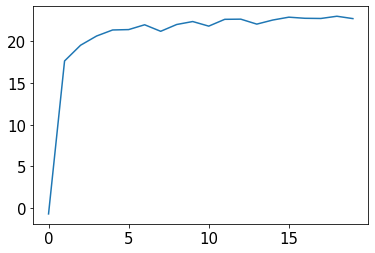

In [5]:
rho = 0.6
k = 24
print(df_nnanti_results.loc[(df_nnanti_results['Model'] == 'WSM') & (df_nnanti_results['rho'] == rho)].iloc[k]['SINR'])
plt.plot(df_nnanti_results.loc[(df_nnanti_results['Model'] == 'WSM') & (df_nnanti_results['rho'] == rho)].iloc[k]['SINRlist'])

rho = df_nnanti_results.loc[(df_nnanti_results['Model'] == 'WSM') & (df_nnanti_results['rho'] == rho)].iloc[k]['rho']
trial = df_nnanti_results.loc[(df_nnanti_results['Model'] == 'WSM') & (df_nnanti_results['rho'] == rho)].iloc[k]['trial']
seed = df_nnanti_results.loc[(df_nnanti_results['Model'] == 'WSM') & (df_nnanti_results['rho'] == rho)].iloc[k]['seed']
Wf = df_nnanti_results.loc[(df_nnanti_results['Model'] == 'WSM') & (df_nnanti_results['rho'] == rho)].iloc[k]['Wf']

A = df_nnanti_results.loc[(df_nnanti_results['Model'] == 'CorInfoMax') & (df_nnanti_results['seed'] == seed) & (df_nnanti_results['rho'] == rho)].iloc[0]['A']
S = df_nnanti_results.loc[(df_nnanti_results['Model'] == 'CorInfoMax') & (df_nnanti_results['seed'] == seed) & (df_nnanti_results['rho'] == rho)].iloc[0]['S']
Xnoisy = df_nnanti_results.loc[(df_nnanti_results['Model'] == 'CorInfoMax') & (df_nnanti_results['seed'] == seed) & (df_nnanti_results['rho'] == rho)].iloc[0]['X']
X = Xnoisy.copy()

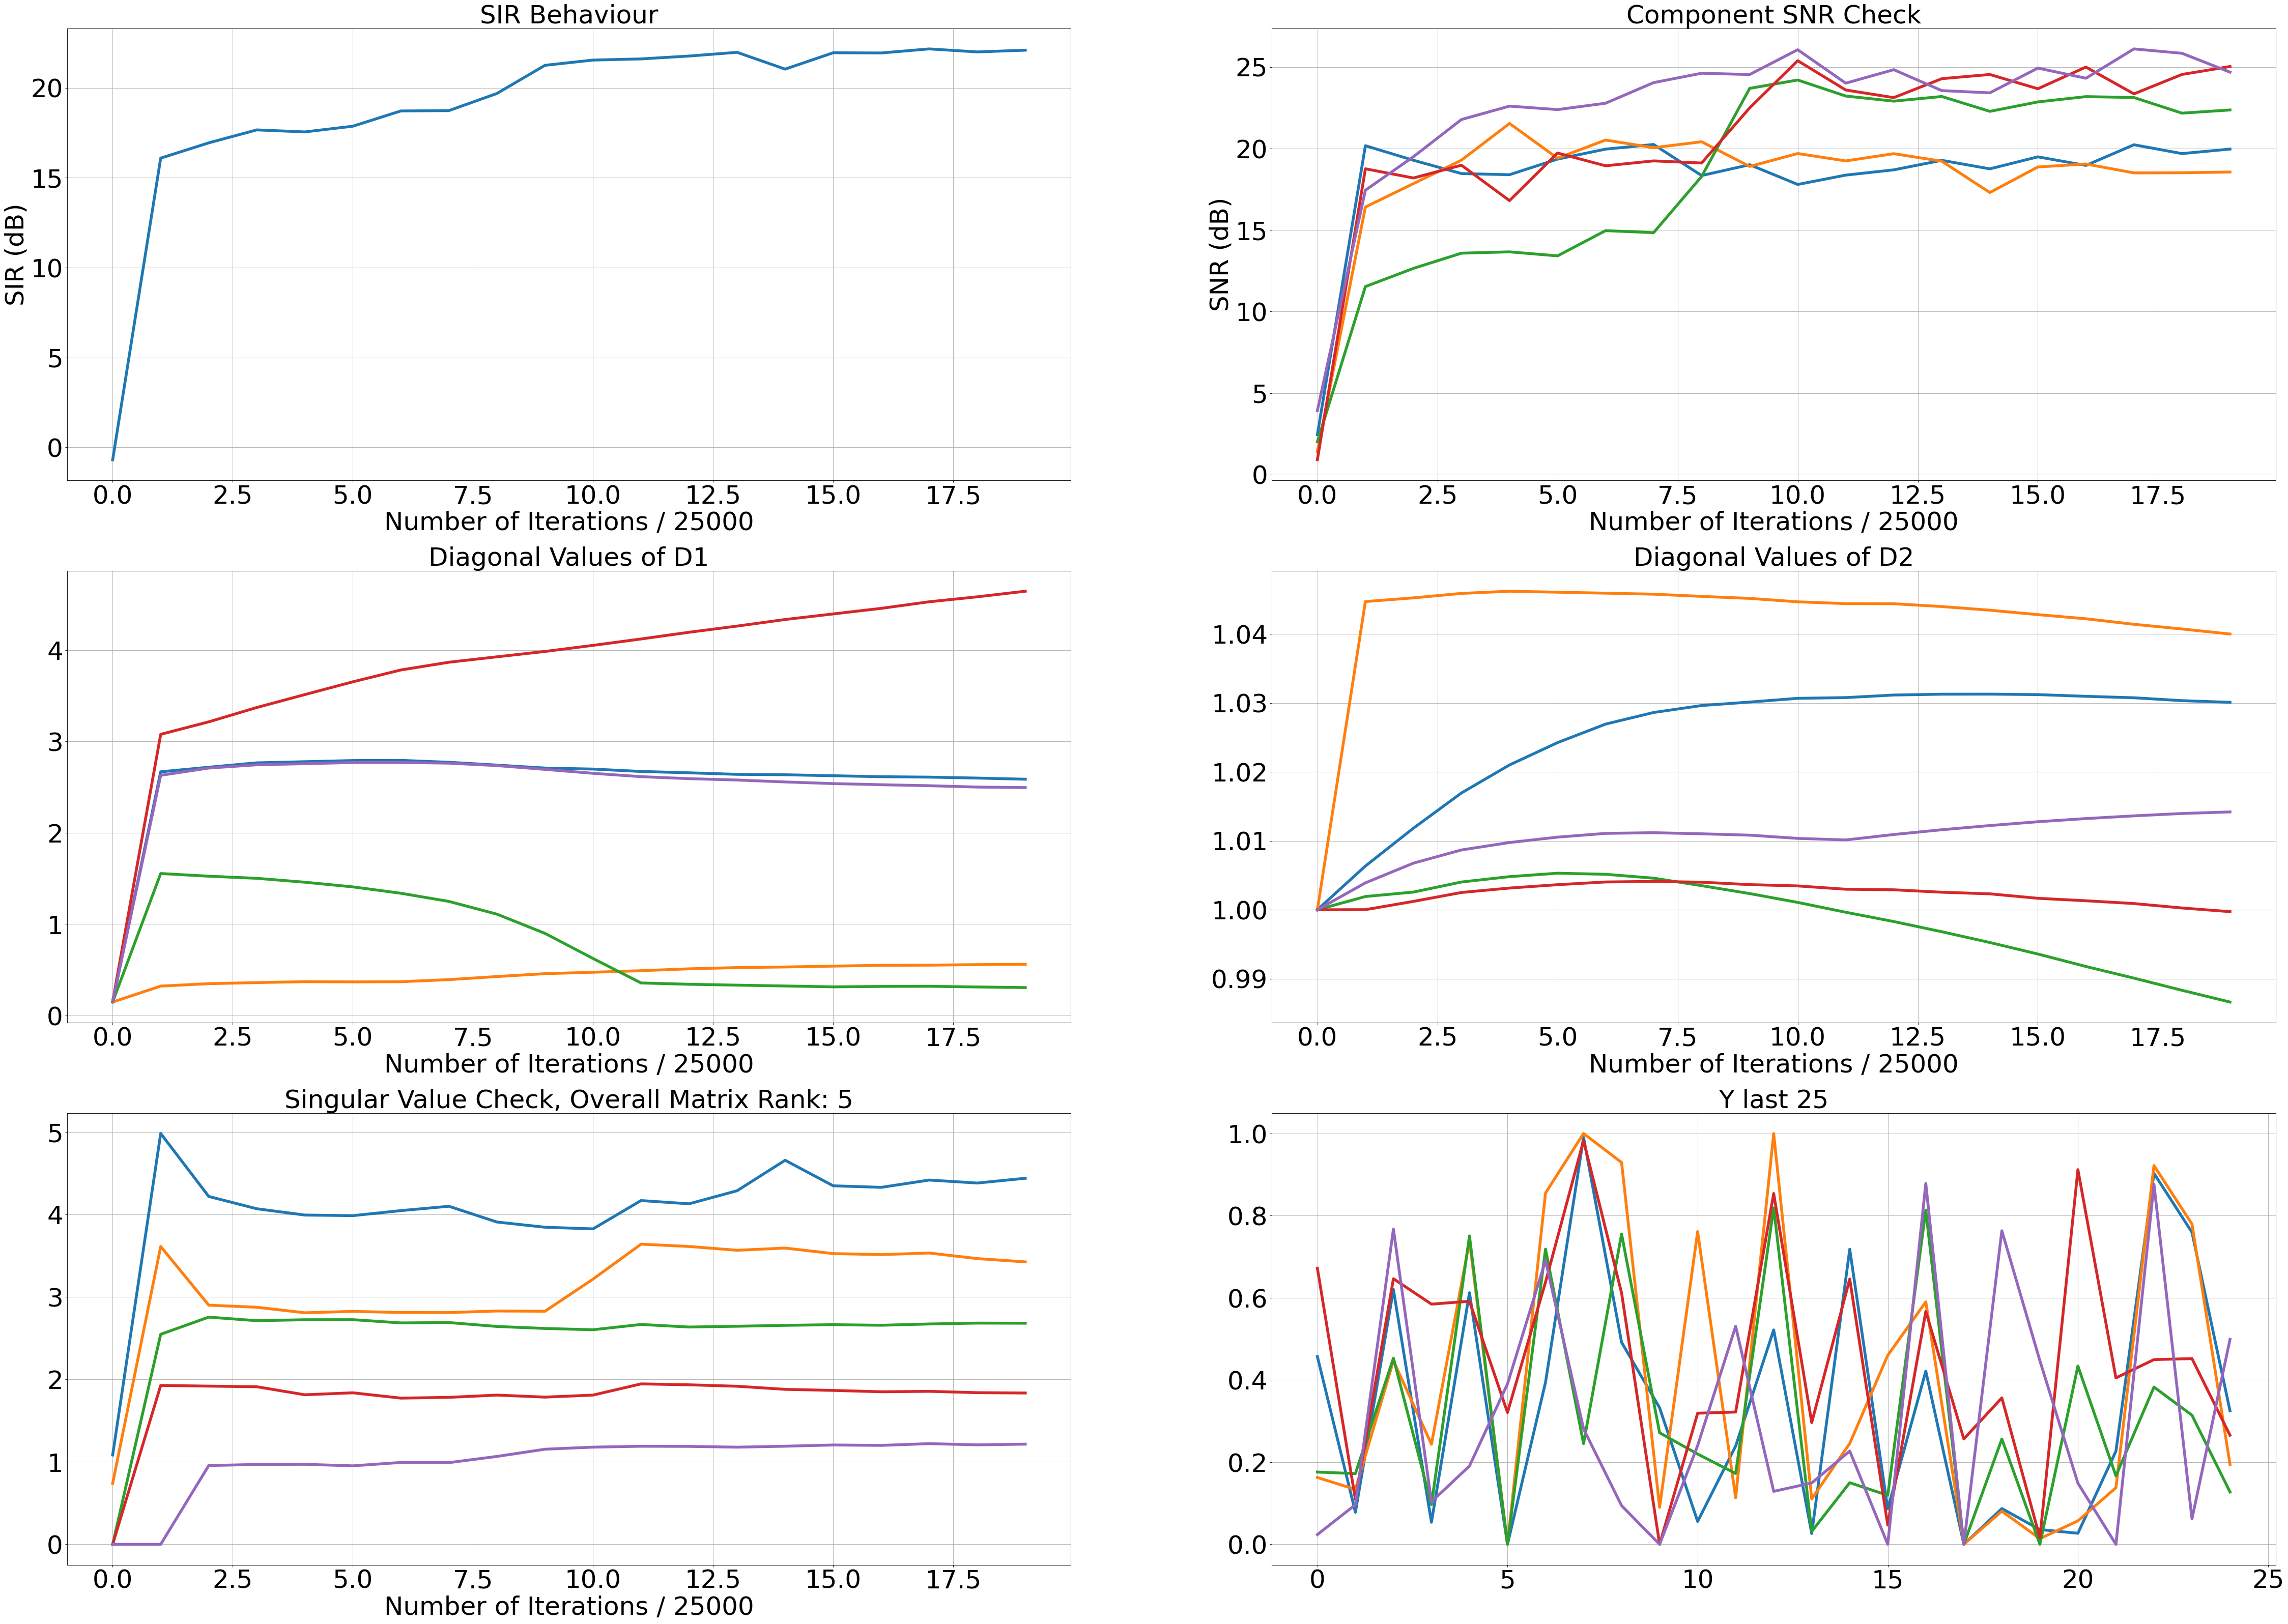

100%|██████████| 500000/500000 [07:37<00:00, 1091.79it/s]


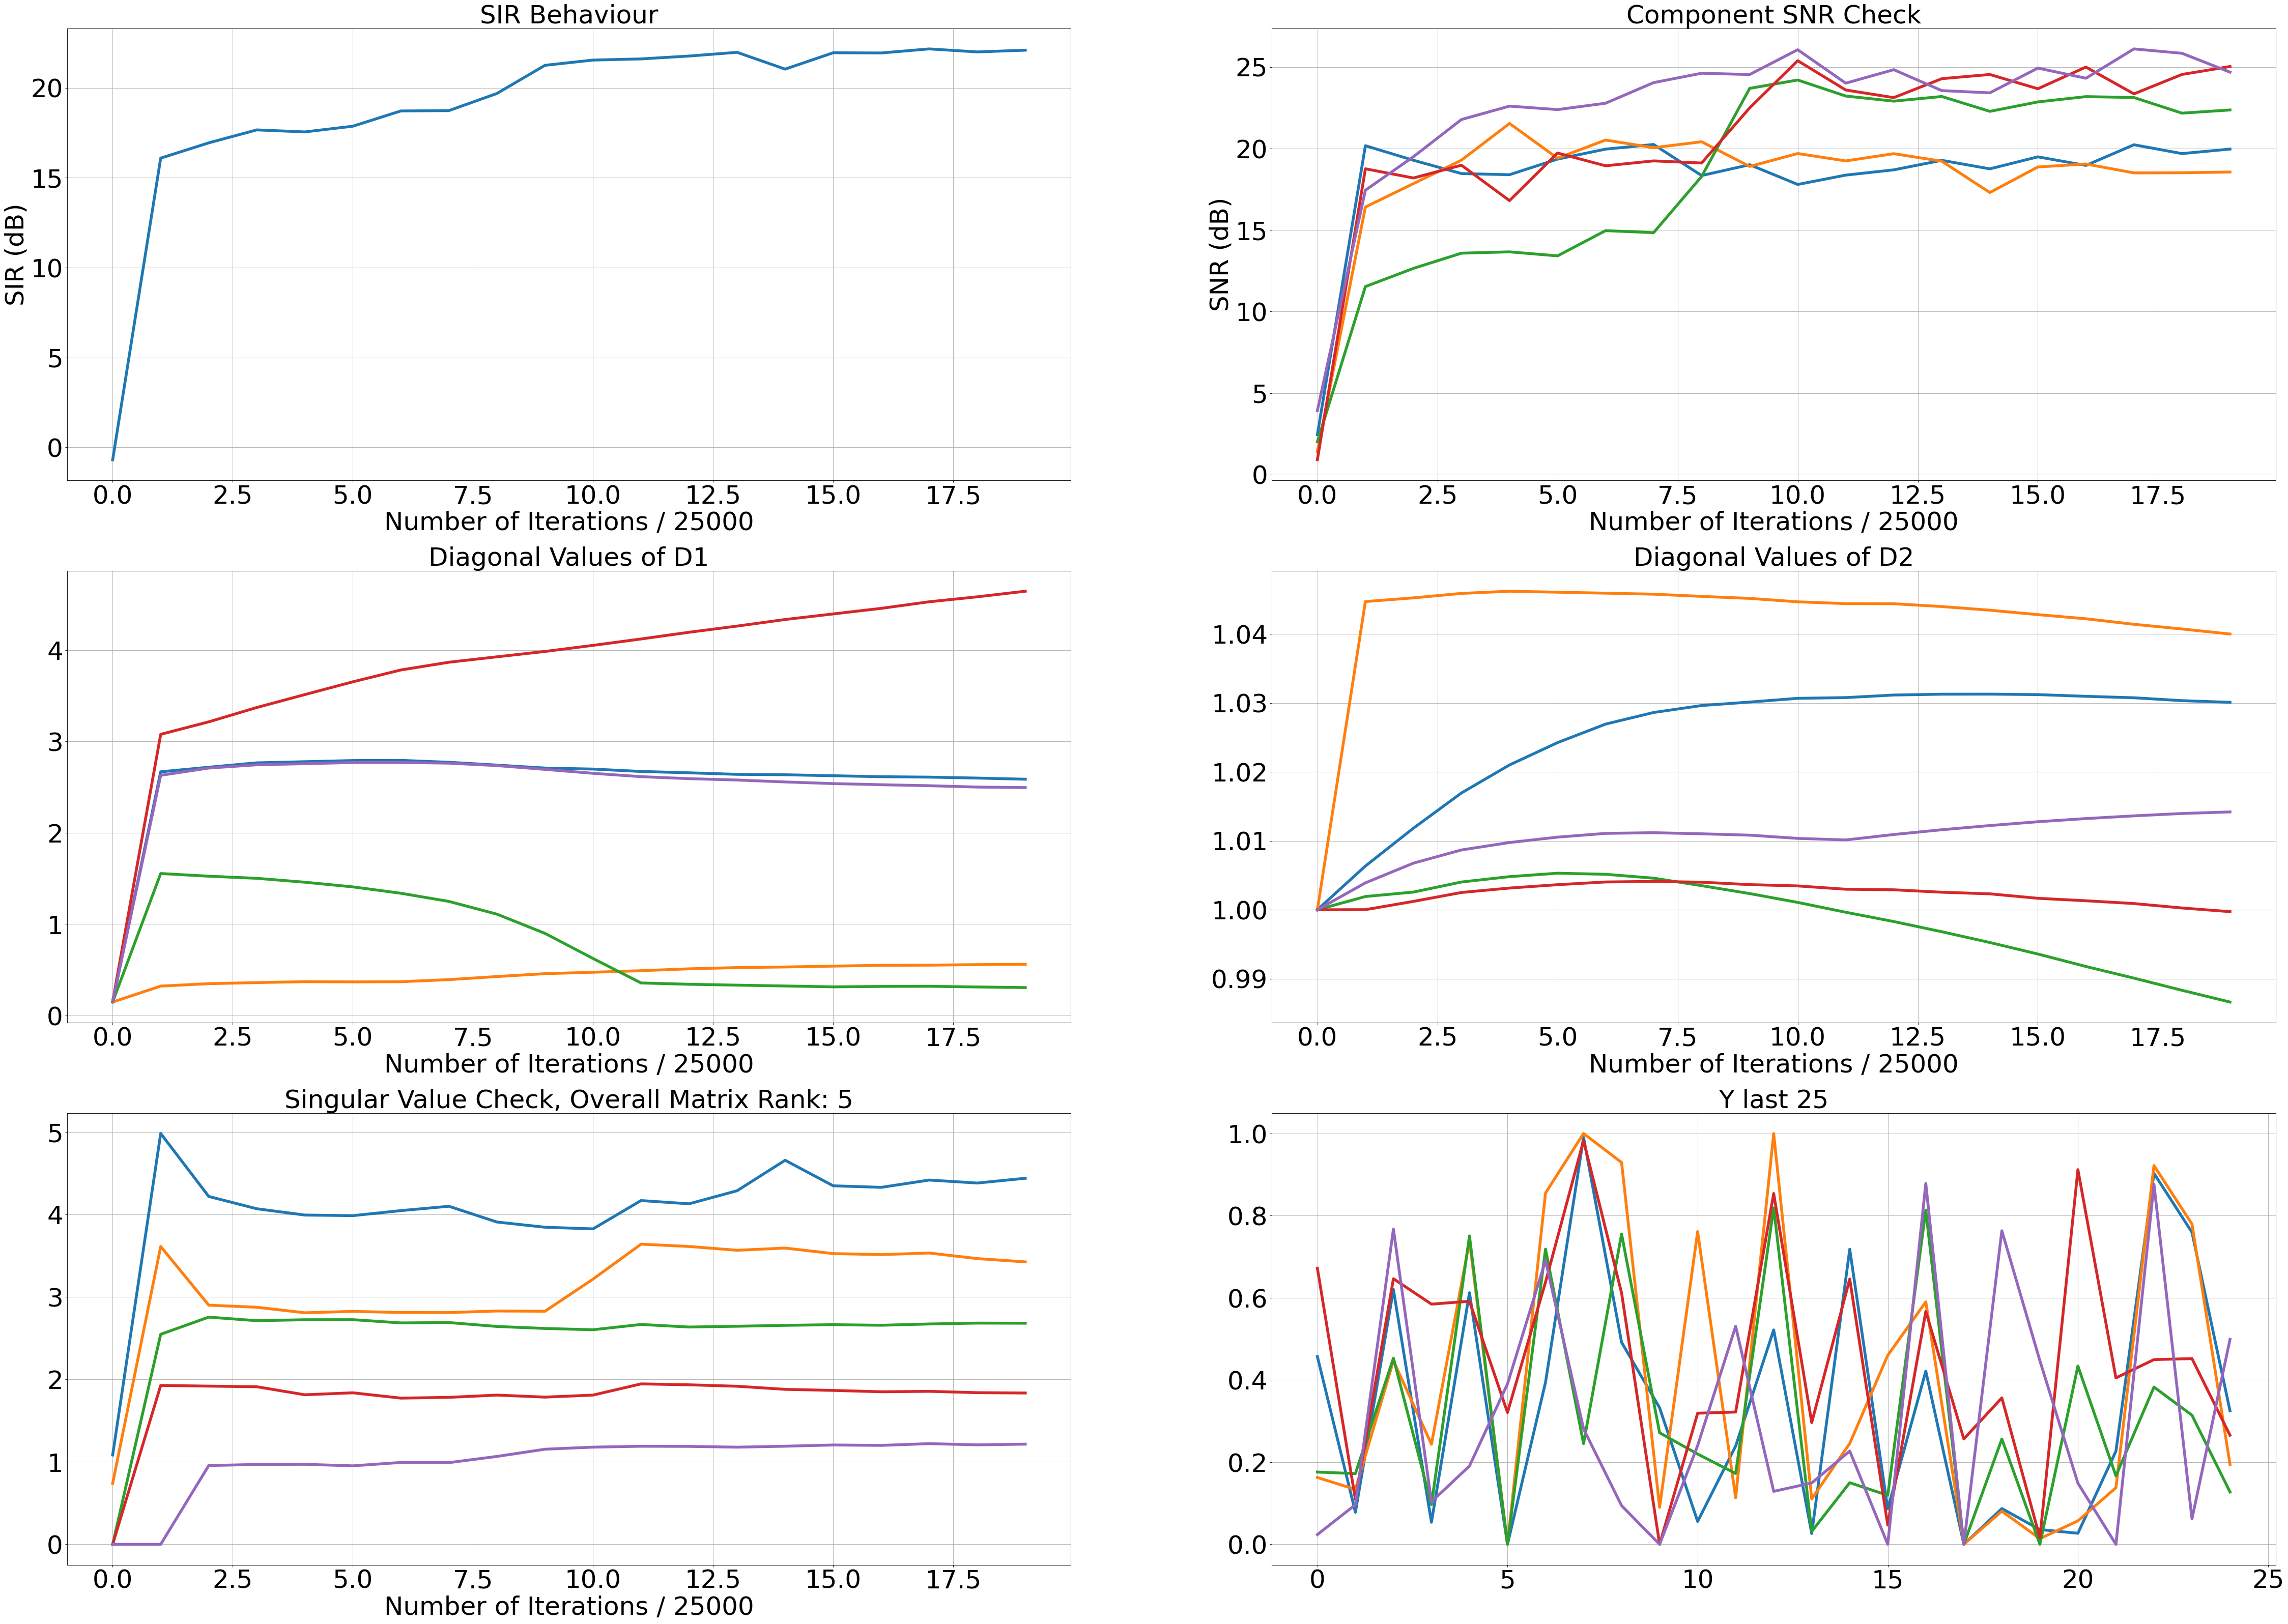

In [6]:
WSM_INPUT_STD = 0.28
XnoisyWSM = (WSM_INPUT_STD * (Xnoisy / Xnoisy.std(1)[:,np.newaxis]))
debug_iteration_point =25000
if rho > 0.4:
    gamma_start = 0.05
    gamma_stop = 5 * 1e-4
else:
    gamma_start = 0.05
    gamma_stop = 5 * 1e-4

gammaM_start = [gamma_start, gamma_start]
gammaM_stop = [gamma_stop, gamma_stop]
gammaW_start = [gamma_start, gamma_start]
gammaW_stop = [gamma_stop, gamma_stop]

OUTPUT_COMP_TOL = 1e-7
MAX_OUT_ITERATIONS = 3000
LayerGains = [1, 1]
LayerMinimumGains = np.array([1e-3, 1e-3])
LayerMaximumGains = np.array([1e6, 20])
WScalings = [0.0033, 0.0033]
GamScalings = [1.7, 1]
zeta = 1 * 1e-5
beta = 0.5
muD = np.array([1.0, 1*1e-2])

s_dim = S.shape[0]
x_dim = X.shape[0]
h_dim = s_dim
samples = S.shape[1]
W_HX = np.eye(h_dim, x_dim)
W_YH = np.eye(s_dim, h_dim)

neural_dynamic_iterations = 500
neural_lr_start = 0.5
neural_lr_stop = 0.05
synaptic_lr_rule="divide_by_log_index"
neural_loop_lr_rule = "divide_by_slow_loop_index"
neural_lr_decay_multiplier = 0.005
hidden_layer_gain=100
neural_OUTPUT_COMP_TOL = OUTPUT_COMP_TOL

synaptic_lr_decay_divider = 1
clip_gain_gradients=False
gain_grads_clipping_multiplier = 1

modelWSM = OnlineWSMBSS(
                        s_dim=s_dim,
                        x_dim=x_dim,
                        h_dim=h_dim,
                        gammaM_start=gammaM_start,
                        gammaM_stop=gammaM_stop,
                        gammaW_start=gammaW_start,
                        gammaW_stop=gammaW_stop,
                        beta=beta,
                        zeta=zeta,
                        muD=muD,
                        WScalings=WScalings,
                        GamScalings=GamScalings,
                        W_HX=W_HX,
                        W_YH=W_YH,
                        DScalings=LayerGains,
                        LayerMinimumGains=LayerMinimumGains,
                        LayerMaximumGains=LayerMaximumGains,
                        neural_OUTPUT_COMP_TOL=OUTPUT_COMP_TOL,
                        set_ground_truth=True,
                        S=S,
                        A=A,
                    )


with Timer() as t:
    modelWSM.fit_batch_nnantisparse(
                                    XnoisyWSM,
                                    n_epochs=1,
                                    neural_dynamic_iterations=500,
                                    neural_lr_start=neural_lr_start,
                                    neural_lr_stop=neural_lr_stop,
                                    neural_fast_start = True,
                                    synaptic_lr_rule=synaptic_lr_rule,
                                    neural_loop_lr_rule=neural_loop_lr_rule,
                                    synaptic_lr_decay_divider=synaptic_lr_decay_divider,
                                    neural_lr_decay_multiplier=neural_lr_decay_multiplier,
                                    hidden_layer_gain=hidden_layer_gain,
                                    clip_gain_gradients=clip_gain_gradients,
                                    gain_grads_clipping_multiplier = gain_grads_clipping_multiplier,
                                    use_newton_steps_for_gains = False,
                                    shuffle=True,
                                    debug_iteration_point=debug_iteration_point,
                                    plot_in_jupyter=True,
                                )

In [10]:
Wf = modelWSM.compute_overall_mapping(return_mapping=True)
Y = Wf @ XnoisyWSM
Y_ = signed_and_permutation_corrected_sourcesV2(S, Y)
coef_ = ((Y_ * S).sum(axis=1) / (Y_ * Y_).sum(axis=1)).reshape(-1, 1)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr_jit(S, Y_)))

SINRwsm = 10 * np.log10(CalculateSINRjit(Y_, S)[0])

print("Overall SINR : {}".format(SINRwsm))

Component SNR Values : [19.9675031  20.18931739 21.21624415 25.1999818  28.124365  ]

Overall SINR : 22.60723029531567
